### Тема: работа с текстом (пример классификации по тематикам)

**Задание:**

1. Найти набор данных с текстами для классификации (анализ тональности, классификация по тематикам)
2. Разобрать данный пример, загрузить свои данные.
3. Посмотреть, что больше влияет на качество обучения: увеличение количества слов в словаре, выходная размерность эмбеддинга или количество элементов LSTM/GRU

*Указание к выполнению.*
В задаче анализа текстов данные слишком разбухают, модули LSTM/GRU в ходе работы выполняют много арифметических операций, поэтому эти скрипты лучше запускать в высокопроизводительной среде или в Google Colab **в режиме поддержки T4 GPU**


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#1. Найти набор данных с текстами для классификации (анализ тональности, классификация по тематикам)
# Датасет с постами из твиттера по поводу коронавируса для анализа тональности
#UserName	и ScreenName - id
#Location	- местоположение
#TweetAt - время написания поста
#OriginalTweet - текст поста
#Sentiment - тональность (Extremely Negative - Negative - Neutral - Positive - Extremely Positive)
train_data = pd.read_csv("Corona_NLP_train.csv", encoding='latin_1')
test_data = pd.read_csv("Corona_NLP_test.csv", encoding='latin_1')

In [4]:
train_data.drop_duplicates(inplace= True)
test_data.drop_duplicates(inplace=True)

train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

In [5]:
#поменяем все нейтральные на 0, позитивные на 1, негативные на 2
def change_sentiment(sentiment):
    if sentiment == "Extremely Positive":
        return 1
    elif sentiment == "Extremely Negative":
        return 2
    elif sentiment == "Positive":
        return 1
    elif sentiment == "Negative":
        return 2
    else:
        return 0

In [6]:
train_data['Sentiment'] = train_data['Sentiment'].apply(lambda x: change_sentiment(x))
test_data['Sentiment'] = test_data['Sentiment'].apply(lambda x: change_sentiment(x))

In [7]:
train_data

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,1
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,1
...,...,...,...,...,...,...
41147,44946,89898,"Brooklyn, NY",14-04-2020,YÂall really shitting that much more at home?...,2
41149,44948,89900,"Toronto, Ontario",14-04-2020,Still shocked by the number of #Toronto superm...,2
41150,44949,89901,OHIO,14-04-2020,I never that weÂd be in a situation &amp; wor...,1
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,0


In [8]:
test_data

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,2
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,1
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,2
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,0
5,6,44958,Los Angeles,03-03-2020,Do you remember the last time you paid $2.99 a...,0
...,...,...,...,...,...,...
3792,3793,48745,Washington D.C.,16-03-2020,"@RicePolitics @MDCounties Craig, will you call...",2
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,1
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,2
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,0


In [9]:
#оставляем только текст и окраску
train_data = train_data.iloc[:,4:]
test_data = test_data.iloc[:,4:]

In [10]:
train_data.shape, test_data.shape

((32567, 2), (2964, 2))

In [11]:
X_train = train_data['OriginalTweet']
X_test = test_data['OriginalTweet']

Y_train = train_data['Sentiment']
Y_test = test_data['Sentiment']

In [12]:
#2. Разобрать данный пример, загрузить свои данные
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Bidirectional, Embedding, Input, Dropout

In [13]:
#Токенизация
maxWordCount = 1000 # количество слов в словаре

tokenizer = Tokenizer(maxWordCount)
tokenizer.fit_on_texts(X_train.to_numpy())

In [14]:
tokenizer.word_index
#Одни из популярных слов - fake, donating, toiletpapercrisis, ebay и др.

{'the': 1,
 'to': 2,
 '\r\r': 3,
 't': 4,
 'co': 5,
 'https': 6,
 'and': 7,
 'of': 8,
 'a': 9,
 'in': 10,
 'coronavirus': 11,
 '19': 12,
 'covid': 13,
 'for': 14,
 'is': 15,
 'are': 16,
 'on': 17,
 'you': 18,
 'i': 19,
 'this': 20,
 'at': 21,
 'prices': 22,
 'food': 23,
 'supermarket': 24,
 'store': 25,
 'with': 26,
 'we': 27,
 'grocery': 28,
 'that': 29,
 'as': 30,
 'have': 31,
 'be': 32,
 'it': 33,
 'from': 34,
 'amp': 35,
 'people': 36,
 'covid19': 37,
 'consumer': 38,
 'all': 39,
 'your': 40,
 'will': 41,
 'not': 42,
 'our': 43,
 'my': 44,
 'up': 45,
 'has': 46,
 'out': 47,
 'more': 48,
 'or': 49,
 'by': 50,
 'they': 51,
 'can': 52,
 'shopping': 53,
 'online': 54,
 'if': 55,
 'but': 56,
 'how': 57,
 'during': 58,
 'pandemic': 59,
 'their': 60,
 'now': 61,
 'so': 62,
 'about': 63,
 'no': 64,
 'get': 65,
 'need': 66,
 'what': 67,
 'who': 68,
 'just': 69,
 'workers': 70,
 'panic': 71,
 'us': 72,
 'time': 73,
 'demand': 74,
 'like': 75,
 'do': 76,
 'sanitizer': 77,
 'an': 78,
 'home': 

In [15]:
#Ищем длину вектора
lens = np.array([len(e) for e in X_train])

In [16]:
print(np.mean(lens))
print(np.median(lens))
print(np.max(lens))
print(np.min(lens))

204.80268369822213
215.0
355
11


In [17]:
#Векторизация и пэддинг
inputSeqLength = 256

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=inputSeqLength, padding='post', truncating = "post")
X_test_pad = pad_sequences(X_test_seq, maxlen=inputSeqLength, padding='post', truncating = "post")

In [18]:
X_train_pad[3]

array([ 30, 186,   8,   1, 184,  13,  12, 625, 844,  47,   8, 845, 199,
       159,  36,   2, 593, 122,   2, 701, 675, 196,  86,  77,  23, 109,
       113,   7, 107, 290, 468,   6,   4,   5,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [19]:
#3. Посмотреть, что больше влияет на качество обучения:
#   - увеличение количества слов в словаре,
#   - выходная размерность эмбеддинга
#   - количество элементов LSTM/GRU
inputShape = X_train_pad.shape[1]
X_train_pad.shape

(32567, 256)

In [20]:
txtModel = Sequential([
    Input(shape = (inputShape, )),
    # Параметры слоя эмбеддинга:
    # input_dim - задает размер словаря (если задать некорректно, то будет ошибка вычислений)
    # output_dim - размерность выходных векторов эмбединга
    # input_length - размернсть входных последовательнстей
    Embedding(input_dim = maxWordCount, output_dim = 16), #, input_length = inputShape),
    #LSTM( units = 32 ),
    Bidirectional(GRU( units = 32 )),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(units = 3, activation = "softmax")
])

txtModel.compile( loss = "sparse_categorical_crossentropy",
                  optimizer = "adam", metrics = ["sparse_categorical_accuracy"])

In [21]:
hist = txtModel.fit(X_train_pad, Y_train, epochs = 10, batch_size = 32, validation_split = 0.2 )

Epoch 1/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 56s 68ms/step - loss: 0.9582 - sparse_categorical_accuracy: 0.5109 - val_loss: 0.6910 - val_sparse_categorical_accuracy: 0.7140
Epoch 2/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step - loss: 0.6649 - sparse_categorical_accuracy: 0.7342 - val_loss: 0.6460 - val_sparse_categorical_accuracy: 0.7364
Epoch 3/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 58s 72ms/step - loss: 0.6436 - sparse_categorical_accuracy: 0.7452 - val_loss: 0.6525 - val_sparse_categorical_accuracy: 0.7343
Epoch 4/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step - loss: 0.6262 - sparse_categorical_accuracy: 0.7536 - val_loss: 0.6441 - val_sparse_categorical_accuracy: 0.7392
Epoch 5/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step - loss: 0.6196 - sparse_categorical_accuracy: 0.7581 - val_loss: 0.6429 - val_sparse_categorical_accuracy: 0.7347
Epoch 6/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 60s 73ms/step - loss: 0.6241 - sparse_categorical_accuracy: 0.7535 - val_loss: 0.6509 - val_sparse_categorical_accuracy:

In [22]:
txtModel.save("GRU_ep10-b32.keras")

In [23]:
txtModel.evaluate(X_test_pad, Y_test)
#0.680939257144928, 0.7145748734474182

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6510 - sparse_categorical_accuracy: 0.7273


[0.6687759757041931, 0.7179487347602844]

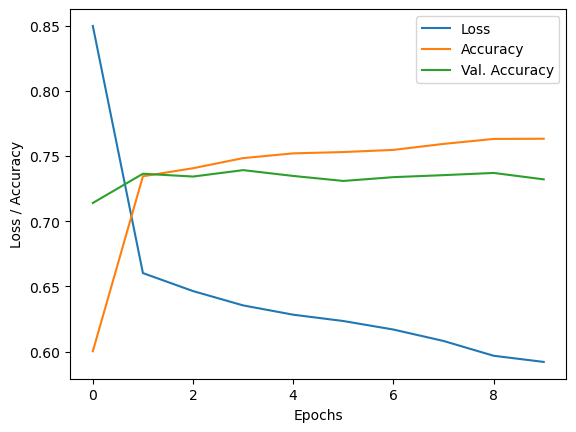

In [24]:
plt.plot( hist.history["loss"], label = "Loss" )
plt.plot( hist.history["sparse_categorical_accuracy"], label = "Accuracy" )
plt.plot( hist.history["val_sparse_categorical_accuracy"], label = "Val. Accuracy" )
plt.xlabel("Epochs")
plt.ylabel("Loss / Accuracy")
plt.legend()
plt.show()

Увеличиваем количество слов в словаре

In [26]:
#Токенизация
maxWordCount = 2000 # количество слов в словаре

tokenizer = Tokenizer(maxWordCount)
tokenizer.fit_on_texts(X_train.to_numpy())

In [27]:
#Векторизация и пэддинг
inputSeqLength = 256

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=inputSeqLength, padding='post', truncating = "post")
X_test_pad = pad_sequences(X_test_seq, maxlen=inputSeqLength, padding='post', truncating = "post")

In [28]:
#3. Посмотреть, что больше влияет на качество обучения:
#   - увеличение количества слов в словаре,
#   - выходная размерность эмбеддинга
#   - количество элементов LSTM/GRU
inputShape = X_train_pad.shape[1]
X_train_pad.shape

(32567, 256)

In [29]:
more_words_model = Sequential([
    Input(shape = (inputShape, )),
    Embedding(input_dim = maxWordCount, output_dim = 16),
    Bidirectional(GRU( units = 32 )),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(units = 3, activation = "softmax")
])

more_words_model.compile( loss = "sparse_categorical_crossentropy",
                  optimizer = "adam", metrics = ["sparse_categorical_accuracy"])

In [30]:
hist = more_words_model.fit(X_train_pad, Y_train, epochs = 10, batch_size = 32, validation_split = 0.2 )

Epoch 1/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 56s 68ms/step - loss: 0.9619 - sparse_categorical_accuracy: 0.5037 - val_loss: 0.6056 - val_sparse_categorical_accuracy: 0.7657
Epoch 2/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 58s 71ms/step - loss: 0.5586 - sparse_categorical_accuracy: 0.7957 - val_loss: 0.5532 - val_sparse_categorical_accuracy: 0.7931
Epoch 3/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 58s 71ms/step - loss: 0.5245 - sparse_categorical_accuracy: 0.8123 - val_loss: 0.5499 - val_sparse_categorical_accuracy: 0.8049
Epoch 4/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 58s 71ms/step - loss: 0.5014 - sparse_categorical_accuracy: 0.8213 - val_loss: 0.5407 - val_sparse_categorical_accuracy: 0.8030
Epoch 5/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 58s 71ms/step - loss: 0.4889 - sparse_categorical_accuracy: 0.8277 - val_loss: 0.5555 - val_sparse_categorical_accuracy: 0.7987
Epoch 6/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 58s 71ms/step - loss: 0.4718 - sparse_categorical_accuracy: 0.8326 - val_loss: 0.5613 - val_sparse_categorical_accuracy:

In [31]:
more_words_model.save("more_words_model.keras")

In [32]:
more_words_model.evaluate(X_test_pad, Y_test)
#0.595940113067627, 0.7749662399291992

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6056 - sparse_categorical_accuracy: 0.7704


[0.611518919467926, 0.7746288776397705]

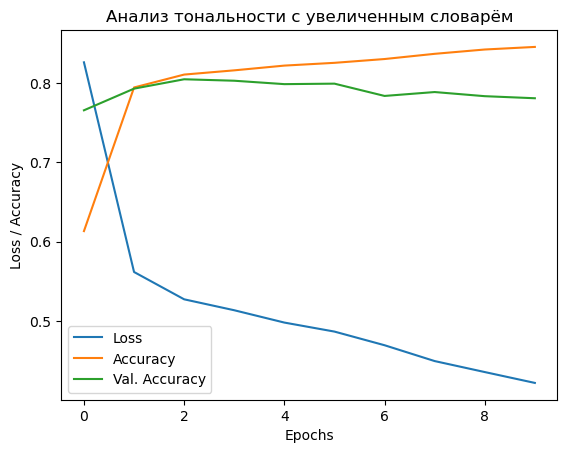

In [33]:
plt.plot( hist.history["loss"], label = "Loss" )
plt.plot( hist.history["sparse_categorical_accuracy"], label = "Accuracy" )
plt.plot( hist.history["val_sparse_categorical_accuracy"], label = "Val. Accuracy" )
plt.xlabel("Epochs")
plt.ylabel("Loss / Accuracy")
plt.title("Анализ тональности с увеличенным словарём")
plt.legend()
plt.show()

Увеличиваем выходную размерность эмбеддинга

In [35]:
#Токенизация
maxWordCount = 1000 # количество слов в словаре

tokenizer = Tokenizer(maxWordCount)
tokenizer.fit_on_texts(X_train.to_numpy())

In [36]:
#Векторизация и пэддинг
inputSeqLength = 256

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=inputSeqLength, padding='post', truncating = "post")
X_test_pad = pad_sequences(X_test_seq, maxlen=inputSeqLength, padding='post', truncating = "post")

In [37]:
#3. Посмотреть, что больше влияет на качество обучения:
#   - увеличение количества слов в словаре,
#   - выходная размерность эмбеддинга
#   - количество элементов LSTM/GRU
inputShape = X_train_pad.shape[1]
X_train_pad.shape

(32567, 256)

In [38]:
more_embedding_model = Sequential([
    Input(shape = (inputShape, )),
    Embedding(input_dim = maxWordCount, output_dim = 64),
    Bidirectional(GRU( units = 32 )),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(units = 3, activation = "softmax")
])

more_embedding_model.compile( loss = "sparse_categorical_crossentropy",
                  optimizer = "adam", metrics = ["sparse_categorical_accuracy"])

In [ ]:
hist = more_embedding_model.fit(X_train_pad, Y_train, epochs = 10, batch_size = 32, validation_split = 0.2 )

Epoch 1/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 64s 77ms/step - loss: 0.9453 - sparse_categorical_accuracy: 0.5111 - val_loss: 0.6483 - val_sparse_categorical_accuracy: 0.7364
Epoch 2/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 95s 116ms/step - loss: 0.6518 - sparse_categorical_accuracy: 0.7403 - val_loss: 0.6365 - val_sparse_categorical_accuracy: 0.7360
Epoch 3/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 603s 741ms/step - loss: 0.6271 - sparse_categorical_accuracy: 0.7495 - val_loss: 0.6374 - val_sparse_categorical_accuracy: 0.7370
Epoch 4/10
652/815 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - loss: 0.6269 - sparse_categorical_accuracy: 0.7513

In [ ]:
more_embedding_model.save("more_embedding_model.keras")

In [ ]:
more_embedding_model.evaluate(X_test_pad, Y_test)
#0.7077611088752747, 0.7068151235580444

In [ ]:
plt.plot( hist.history["loss"], label = "Loss" )
plt.plot( hist.history["sparse_categorical_accuracy"], label = "Accuracy" )
plt.plot( hist.history["val_sparse_categorical_accuracy"], label = "Val. Accuracy" )
plt.xlabel("Epochs")
plt.ylabel("Loss / Accuracy")
plt.title("Анализ тональности с увеличенной выходной размерностью эмбеддинга")
plt.legend()
plt.show()

Увеличиваем количество элементов GRU

In [ ]:
more_GRU_model = Sequential([
    Input(shape = (inputShape, )),
    Embedding(input_dim = maxWordCount, output_dim = 16),
    Bidirectional(GRU( units = 128, return_sequences=True )),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Bidirectional(GRU( units = 32 )),
    Dense(units = 3, activation = "softmax")
])

more_GRU_model.compile( loss = "sparse_categorical_crossentropy",
                  optimizer = "adam", metrics = ["sparse_categorical_accuracy"])

In [ ]:
hist = more_GRU_model.fit(X_train_pad, Y_train, epochs = 10, batch_size = 32, validation_split = 0.2 )

In [ ]:
more_GRU_model.save("more_GRU_model.keras")

In [ ]:
more_GRU_model.evaluate(X_test_pad, Y_test)
#0.6572496891021729, 0.7216598987579346

In [ ]:
plt.plot( hist.history["loss"], label = "Loss" )
plt.plot( hist.history["sparse_categorical_accuracy"], label = "Accuracy" )
plt.plot( hist.history["val_sparse_categorical_accuracy"], label = "Val. Accuracy" )
plt.xlabel("Epochs")
plt.ylabel("Loss / Accuracy")
plt.title("Анализ тональности с увеличенной выходной размерностью эмбеддинга")
plt.legend()
plt.show()

Увеличенный словарь дал больше результата

**---------------------------------------------------**

**Ниже практика**

**---------------------------------------------------**

#### Ecommerce Text Classification

https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification

In [ ]:
import numpy as np
from zipfile import ZipFile
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv("ecommerceDataset.csv", header = None )

In [ ]:
data

In [ ]:
data[0].value_counts()

In [ ]:
data.dropna( inplace = True )
data.info()

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data[0] = le.fit_transform( data[0] )

In [ ]:
X = data[1].to_numpy()
Y = data[0].to_numpy().astype(np.int64)

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, train_size = 0.8)

In [ ]:
sampleInd = 6
data.iloc[sampleInd,1]

In [ ]:
ytrain.shape

### Схема работы с текстом:

* *Текстовое сообщение*
* Токенизация (Tokenizer) -> словарь (обычно ограничивается как сверху так и снизу)
* Векторизация: преобразование в числа (text_to_sequences)
* выравнивание входных векторов (pad_sequences)
* применение эмбеддингов (Embedding) -> векторы эмбеддинга (учет более сложных связей)
* RNN / LSTM / GRU + Dense -> классификация

#### Про эмбеддинги (Embedding)

Краткий смысл:
E("король") - E("мужчина") + E("женщина") -> E("королева

Предобученные эмбеддинги:

* WordToVec
  * модель CBOW: вывод слова из контекста
  * модель skip-gram:  по слову определяет контекст
* Glove

Математически Эмбеддинг - матрица, преобразующая входной вектор

Эмбеддинг — это проекция дискретного пространства (например, слов) в непрерывное пространство (векторы). Его можно рассматривать как матрицу весов, где каждая строка — вектор, соответствующий определённому слову из словаря.

### Токенизация

"Мешок слов" - Bag of Words

TF-IDF   (nt / Nd * log( D / D|t ))

In [ ]:
from keras.preprocessing.text import Tokenizer # DEPRECATED! Новая версия: https://keras.io/keras_hub/api/tokenizers/tokenizer/
from keras.utils import pad_sequences

In [ ]:
maxWordCount = 1000 # количество слов в словаре

# больше параметров: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

tokenizer = Tokenizer( maxWordCount )
tokenizer.fit_on_texts( X )

In [ ]:
# видно, что наиболее распространенные неинформативные слова в виде предлогов, артиклей.
# Для этого обычно используются список стоп-слов (зависит от языка и предметной области)
tokenizer.word_index

In [ ]:
xtrain_enc = tokenizer.texts_to_sequences( xtrain )
xtest_enc = tokenizer.texts_to_sequences( xtest )

#### Проанализируем длины сообщений - нам нужно определиться, каку длину оставляем, т.к. в модель будем подавать только векторы фиксированной длины. Длинные сообщения придется обрезать, слишком короткие - выровнять нулями (пэддинг)

In [ ]:
lens = np.array( [ len(e) for e in X] )

In [ ]:
print(np.mean(lens))
print(np.median(lens))
print(np.max(lens))
print(np.min(lens))

In [ ]:
inputSeqLength = 512 #делаем длину текстов в 512 токенов (слов)

#выравниваем все сообщения: отрезаем хвост (truncating = "post"), добавляем нули тоже в хвосте (padding = "post")
xtrain_pad = pad_sequences( xtrain_enc, maxlen = inputSeqLength, padding = "post", truncating = "post" )
xtest_pad = pad_sequences( xtest_enc, maxlen = inputSeqLength, padding = "post", truncating = "post" )

In [ ]:
xtrain_pad[4]

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Bidirectional, Embedding, Input


In [ ]:
#форма входа нейросети

xtrain_pad.shape

In [ ]:
inputShape = xtrain_pad.shape[1]

txtModel = Sequential([
    Input( shape = (inputShape) ),
    # Параметры слоя эмбеддинга:
    # input_dim - задает размер словаря (если задать некорректно, то будет ошибка вычислений)
    # output_dim - размерность выходных векторов эмбединга
    # input_length - размернсть входных последовательнстей
    Embedding( input_dim = maxWordCount, output_dim = 32, input_length = inputShape ),
    #LSTM( units = 32 ),
    Bidirectional( LSTM( units = 32 ) ),
    Dense( units = len(np.unique(Y)), activation = "softmax" )
])

txtModel.compile( loss = "sparse_categorical_crossentropy",
                  optimizer = "SGD", metrics = ["sparse_categorical_accuracy"])

In [ ]:
txtModel.summary()

In [ ]:
hist = txtModel.fit( xtrain_pad, ytrain,
                    epochs = 10,
                    batch_size = 32, validation_split = 0.2 )

In [ ]:
txtModel.evaluate(xtest_pad, ytest)

In [ ]:
import matplotlib.pyplot as plt

plt.plot( hist.history["loss"], label = "Loss" )
plt.plot( hist.history["sparse_categorical_accuracy"], label = "Accuracy" )
plt.plot( hist.history["val_sparse_categorical_accuracy"], label = "Val. Accuracy" )
plt.xlabel("Epochs")
plt.ylabel("Loss / Accuracy")
plt.legend()
plt.show()